# 🌏 스토리: “여행 리뷰 탐정단”

> 당신은 국내 최대 여행 플랫폼 **DiscoverKorea**의 AI 리뷰 큐레이터입니다.  
> 최근 여행객들의 솔직한 후기 데이터를 분석해, 숨겨진 인기 코스와 만족도를 높여 줄 여행 팁을 발굴해야 합니다.  
> **여행 리뷰 탐정단**으로서 아래 6가지 단계별 과제를 수행하여, 리뷰 데이터를 전처리하고, 핵심 단어를 추출·시각화하며, 비슷한 후기끼리 묶어보세요.  


In [35]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [36]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [37]:
pip install konlpy scikit-learn matplotlib seaborn wordcloud

In [38]:
# 라이브러리 import
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## 1. 형태소 분석 & 품사 태깅
- `extended_travel_reviews_dataset`의 리뷰 텍스트를 불러옵니다.  
- **Okt** 또는 **Mecab** 형태소 분석기를 이용해, 각 문장에 등장하는 **명사(Noun)**와 **형용사(Adjective)**만 추출하세요.  
- 미션:  
  - “경치가 정말 아름답고 힐링이 되었어요. 😊” → `['경치', '아름답다', '힐링']`  


In [39]:
# 1. 형태소 분석 & 품사 태깅
okt = Okt()

# 데이터 로드 (colab에 미리 업로드된 파일 가정)
df = pd.read_csv('/content/travel_reviews_extended.csv')

def extract_nouns_and_adjectives(text):
    tagged_words = okt.pos(text)
    filtered_words = [word for word, pos in tagged_words
                      if pos in ['Noun', 'Adjective']]
    return filtered_words

# 예시 문장 테스트
test_sentence = "경치가 정말 아름답고 힐링이 되었어요. 😊"
result = extract_nouns_and_adjectives(test_sentence)
print("1. 형태소 분석 & 품사 태깅")
print("원본 문장:", test_sentence)
print("추출된 명사/형용사:", result)

1. 형태소 분석 & 품사 태깅
원본 문장: 경치가 정말 아름답고 힐링이 되었어요. 😊
추출된 명사/형용사: ['경치', '정말', '아름답고', '힐링']


## 2. 텍스트 정제(클리닝)
- 원본 리뷰에는 숫자(예: “100명 이상”), 특수문자(“!!!”, “#추천”), 이모지(“😊”, “👍”)와 과도한 공백이 섞여 있습니다.  
- **정규표현식**을 활용해 아래 과정을 수행하세요:  
  1. 숫자·특수문자·이모지를 모두 제거  
  2. 여러 개의 공백(`\s+`)을 하나의 공백으로 통일  
- 미션:  
  - “숙소가   깨끗하고    위치가 편리했어요.” → “숙소가 깨끗하고 위치가 편리했어요”  


In [40]:
# 2. 텍스트 정제(클리닝)
def clean_text(text):
    # 특수문자, 숫자, 이모지 제거
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\d+', '', text)
    # 여러 공백을 단일 공백으로 변환
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 예시 문장 테스트
test_clean_sentence = "숙소가   깨끗하고    위치가 편리했어요."
cleaned_sentence = clean_text(test_clean_sentence)
print("\n2. 텍스트 정제(클리닝)")
print("원본 문장:", test_clean_sentence)
print("정제된 문장:", cleaned_sentence)


2. 텍스트 정제(클리닝)
원본 문장: 숙소가   깨끗하고    위치가 편리했어요.
정제된 문장: 숙소가 깨끗하고 위치가 편리했어요


## 3. 불용어(stopwords) 제거
- 여행 리뷰에 자주 등장하지만 의미를 크게 더해주지 않는 단어들을 제거해야 합니다.  
- 예시 불용어 목록: `{'정말', '것', '있다', 'ㅋㅋ'}`  
- **형태소 분석 결과**에서 위 불용어를 필터링하여 제거하세요.  
- 미션:  
  - `['교통', '불편하다', '이동', '어렵다', '정말']` → `['교통', '불편하다', '이동', '어렵다']`  


In [41]:
# 3. 불용어 제거
def remove_stopwords(morphemes):
    stopwords = {
        '정말', '것', '있다', 'ㅋㅋ', '추천',
        '이', '가', '은', '는', '을', '를',
        '에', '에서', '와', '과', '로', '으로',
        '의', '이다', '하다', '되다', '있다', '않다', '좋았어요', '좋아서'
    }
    return [word for word in morphemes if word not in stopwords]

# 전처리 과정에서 불용어 제거 확인
df['cleaned_review'] = df['review'].apply(clean_text)
df['morphemes'] = df['cleaned_review'].apply(extract_nouns_and_adjectives)
df['filtered_morphemes'] = df['morphemes'].apply(remove_stopwords)
df['processed_review'] = df['filtered_morphemes'].apply(lambda x: ' '.join(x))
# 예시 테스트
test_stopwords = ['교통', '불편하다', '이동', '어렵다', '정말']
filtered_words = remove_stopwords(test_stopwords)
print("\n3. 불용어 제거")
print("원본 단어:", test_stopwords)
print("불용어 제거 후:", filtered_words)


3. 불용어 제거
원본 단어: ['교통', '불편하다', '이동', '어렵다', '정말']
불용어 제거 후: ['교통', '불편하다', '이동', '어렵다']


## 4. Bag-of-Words & Term-Document Matrix 생성
- 불용어 제거까지 마친 코퍼스를 공백으로 이어붙인 문자열 리스트를 준비합니다.  
- `sklearn.feature_extraction.text.CountVectorizer`를 이용해 **문서×단어 행렬**(DTM)을 생성하세요.  
- 생성된 DTM의 **크기(shape)**와 `vocabulary_`(단어 ↔ 열 인덱스) 일부를 출력해 확인합니다.  


In [42]:
# 4. Bag-of-Words & Term-Document Matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['processed_review'])

print("\n4. Bag-of-Words & Term-Document Matrix")
print("DTM Shape:", dtm.shape)
print("단어 사전 일부:", list(vectorizer.vocabulary_.items())[:10])


4. Bag-of-Words & Term-Document Matrix
DTM Shape: (20, 72)
단어 사전 일부: [('경치', 5), ('아름답고', 41), ('힐링', 71), ('음식', 49), ('맛있고', 20), ('가격', 0), ('적당했어요', 54), ('숙소', 38), ('깨끗하고', 11), ('위치', 48)]


## 5. 상위 20개 단어 시각화
- DTM으로부터 각 단어의 전체 등장 빈도를 계산합니다.  
- 빈도 상위 20개 단어를 **막대그래프**로 시각화하여, 여행객들이 자주 언급한 핵심 키워드를 한눈에 파악하세요.  
- (선택) 워드클라우드로도 표현해 보는 것을 권장합니다.  


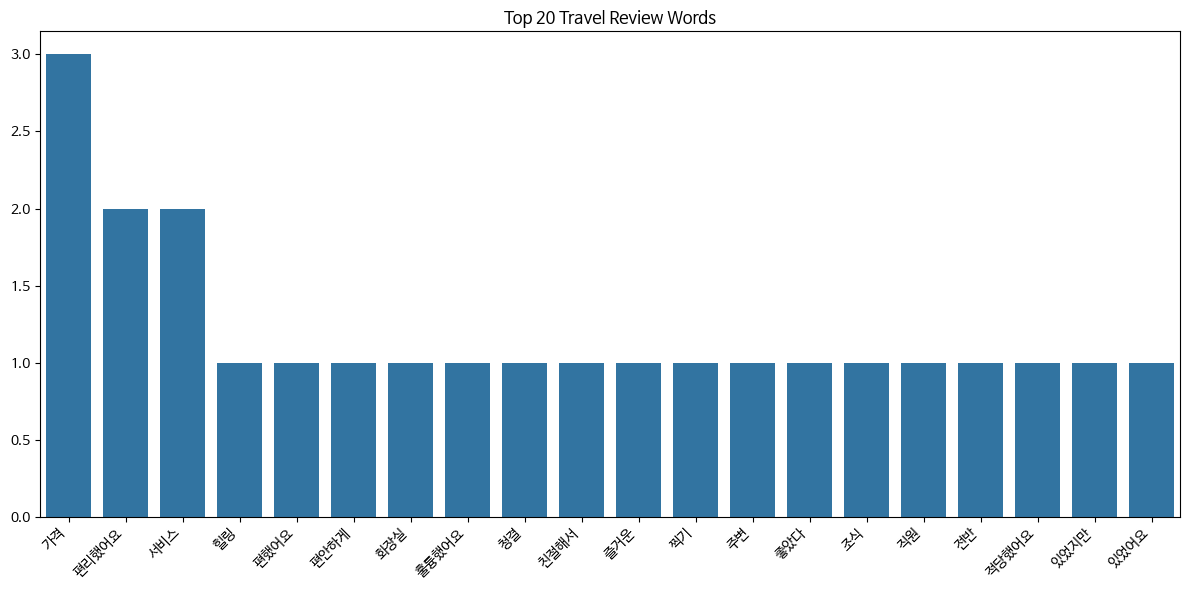

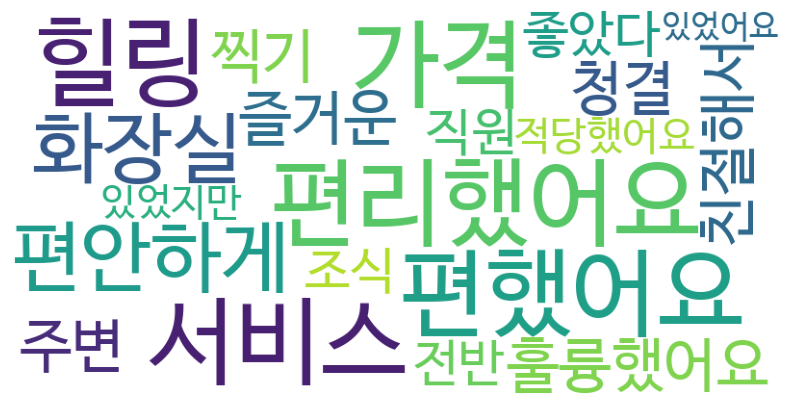

In [43]:
# 5. 상위 20개 단어 시각화
word_freq = dtm.sum(axis=0).A1
top_words_idx = word_freq.argsort()[-20:][::-1]
top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
top_freqs = [word_freq[i] for i in top_words_idx]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words, y=top_freqs)
plt.title('Top 20 Travel Review Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      max_font_size=100,
                      random_state=42).generate(' '.join(top_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 6. TDM을 활용한 유사 문서 탐색 문제
- 4번에서 생성한 TDM을 이용해 **코사인 유사도** 행렬을 계산하세요.  
- 각 리뷰 문서별로 **자기 자신을 제외한** 상위 2개의 유사 문서를 찾아, **(리뷰 ID, 유사도 점수)** 형태로 정리합니다.  
- 결과를 표로 작성하고, 유사도가 높게 나온 **문서 쌍 2개**를 골라, 왜 이 두 리뷰가 서로 유사도가 높았는지 간단히 설명하세요.  

> **결과 예시**  
> ```
> 리뷰 1 유사 문서: [(ID 5, 0.854), (ID 8, 0.832)]
> 리뷰 2 유사 문서: [(ID 3, 0.791), (ID 10, 0.754)]
> ```  


In [44]:
# 6. 유사 문서 탐색
cosine_sim = cosine_similarity(dtm)

def find_similar_docs(sim_matrix, n=2):
    similar_docs = {}
    for i in range(len(sim_matrix)):
        # 자기 자신 제외하고 유사도 높은 문서 찾기
        doc_sims = list(enumerate(sim_matrix[i]))
        doc_sims.pop(i)  # 자기 자신 제거
        similar_docs[i] = sorted(doc_sims, key=lambda x: x[1], reverse=True)[:n]
    return similar_docs

similar_documents = find_similar_docs(cosine_sim)

print("\n6. 유사 문서 탐색")
# 결과 출력
for doc_id, similar_pairs in similar_documents.items():
    print(f"리뷰 {doc_id} 유사 문서: {similar_pairs}")

    # 유사도 높은 문서 쌍 2개 설명
    if doc_id < 2:
        print(f"리뷰 {doc_id} 원문: {df['review'].iloc[doc_id]}")
        for similar_doc_id, similarity in similar_pairs:
            print(f"유사 리뷰 {similar_doc_id} 원문: {df['review'].iloc[similar_doc_id]}")
            print(f"유사도: {similarity}\n")


6. 유사 문서 탐색
리뷰 0 유사 문서: [(1, np.float64(0.0)), (2, np.float64(0.0))]
리뷰 0 원문: 경치가 정말 아름답고 힐링이 되었어요. 😊
유사 리뷰 1 원문: 음식이 맛있고 가격도 적당했어요!!!
유사도: 0.0

유사 리뷰 2 원문: 숙소가   깨끗하고    위치가 편리했어요.
유사도: 0.0

리뷰 1 유사 문서: [(8, np.float64(0.25)), (18, np.float64(0.22360679774997896))]
리뷰 1 원문: 음식이 맛있고 가격도 적당했어요!!!
유사 리뷰 8 원문: 가격 대비 성능이 정말 훌륭했어요.
유사도: 0.25

유사 리뷰 18 원문: 가격이 조금 비싸지만 서비스가 좋아서 만족한다.
유사도: 0.22360679774997896

리뷰 2 유사 문서: [(9, np.float64(0.25)), (0, np.float64(0.0))]
리뷰 3 유사 문서: [(0, np.float64(0.0)), (1, np.float64(0.0))]
리뷰 4 유사 문서: [(0, np.float64(0.0)), (1, np.float64(0.0))]
리뷰 5 유사 문서: [(18, np.float64(0.25819888974716115)), (0, np.float64(0.0))]
리뷰 6 유사 문서: [(0, np.float64(0.0)), (1, np.float64(0.0))]
리뷰 7 유사 문서: [(0, np.float64(0.0)), (1, np.float64(0.0))]
리뷰 8 유사 문서: [(1, np.float64(0.25)), (18, np.float64(0.22360679774997896))]
리뷰 9 유사 문서: [(2, np.float64(0.25)), (0, np.float64(0.0))]
리뷰 10 유사 문서: [(0, np.float64(0.0)), (1, np.float64(0.0))]
리뷰 11 유사 문서: [(0, np.float64(0.0)), (1, np

In [45]:
# 유사 문서 분석 및 표 작성
import pandas as pd

# 유사도 높은 문서 쌍 선별
high_similarity_pairs = []

for doc_id, similar_docs in similar_documents.items():
    for similar_doc_id, similarity in similar_docs:
        if similarity > 0.2:  # 유의미한 유사도 기준
            high_similarity_pairs.append({
                '원본 리뷰 ID': doc_id,
                '원본 리뷰': df['review'].iloc[doc_id],
                '유사 리뷰 ID': similar_doc_id,
                '유사 리뷰': df['review'].iloc[similar_doc_id],
                '유사도': similarity
            })

# 유사 문서 DataFrame으로 변환
similarity_df = pd.DataFrame(high_similarity_pairs)
print("\n유사도 높은 문서 쌍:")
print(similarity_df)

# 상위 2개 유사 문서 쌍 분석
print("\n유사 문서 쌍 상세 분석:")

# 가장 유사도 높은 두 문서 쌍 선택
top_pairs = similarity_df.sort_values('유사도', ascending=False).head(2)

for idx, row in top_pairs.iterrows():
    print(f"\n문서 쌍 {idx+1}:")
    print(f"원본 리뷰 (ID {row['원본 리뷰 ID']}): {row['원본 리뷰']}")
    print(f"유사 리뷰 (ID {row['유사 리뷰 ID']}): {row['유사 리뷰']}")
    print(f"유사도: {row['유사도']}")

    # 유사도가 높은 이유 분석
    print("\n유사도가 높은 이유:")

    # 공통 키워드 찾기
    original_words = set(extract_nouns_and_adjectives(row['원본 리뷰']))
    similar_words = set(extract_nouns_and_adjectives(row['유사 리뷰']))

    common_words = original_words.intersection(similar_words)
    print("공통 키워드:", common_words)


유사도 높은 문서 쌍:
   원본 리뷰 ID                       원본 리뷰  유사 리뷰 ID                       유사 리뷰  \
0         1        음식이 맛있고 가격도 적당했어요!!!         8         가격 대비 성능이 정말 훌륭했어요.   
1         1        음식이 맛있고 가격도 적당했어요!!!        18  가격이 조금 비싸지만 서비스가 좋아서 만족한다.   
2         2    숙소가   깨끗하고    위치가 편리했어요.         9     주변 관광지가 가까워서 편리했어요. #추천   
3         5     서비스가 좋아서 다음에 또 방문하고 싶다.        18  가격이 조금 비싸지만 서비스가 좋아서 만족한다.   
4         8         가격 대비 성능이 정말 훌륭했어요.         1        음식이 맛있고 가격도 적당했어요!!!   
5         8         가격 대비 성능이 정말 훌륭했어요.        18  가격이 조금 비싸지만 서비스가 좋아서 만족한다.   
6         9     주변 관광지가 가까워서 편리했어요. #추천         2    숙소가   깨끗하고    위치가 편리했어요.   
7        18  가격이 조금 비싸지만 서비스가 좋아서 만족한다.         5     서비스가 좋아서 다음에 또 방문하고 싶다.   
8        18  가격이 조금 비싸지만 서비스가 좋아서 만족한다.         1        음식이 맛있고 가격도 적당했어요!!!   

        유사도  
0  0.250000  
1  0.223607  
2  0.250000  
3  0.258199  
4  0.250000  
5  0.223607  
6  0.250000  
7  0.258199  
8  0.223607  

유사 문서 쌍 상세 분석:

문서 쌍 4:
원본 리뷰 (ID 

In [46]:
# 상위 5개 유사 문서 쌍 출력
top_pairs = similarity_df.sort_values('유사도', ascending=False).head(5)
print("\n상위 5개 유사 문서 쌍:")
print(top_pairs[['원본 리뷰', '유사 리뷰', '유사도']])

# 각 문서 쌍에 대한 상세 분석
for idx, row in top_pairs.iterrows():
    print(f"\n문서 쌍 {idx+1}:")
    print(f"원본 리뷰: {row['원본 리뷰']}")
    print(f"유사 리뷰: {row['유사 리뷰']}")
    print(f"유사도: {row['유사도']}")

    # 공통 키워드 찾기
    original_words = set(extract_nouns_and_adjectives(row['원본 리뷰']))
    similar_words = set(extract_nouns_and_adjectives(row['유사 리뷰']))

    common_words = original_words.intersection(similar_words)
    print("공통 키워드:", common_words)


상위 5개 유사 문서 쌍:
                        원본 리뷰                       유사 리뷰       유사도
3     서비스가 좋아서 다음에 또 방문하고 싶다.  가격이 조금 비싸지만 서비스가 좋아서 만족한다.  0.258199
7  가격이 조금 비싸지만 서비스가 좋아서 만족한다.     서비스가 좋아서 다음에 또 방문하고 싶다.  0.258199
0        음식이 맛있고 가격도 적당했어요!!!         가격 대비 성능이 정말 훌륭했어요.  0.250000
4         가격 대비 성능이 정말 훌륭했어요.        음식이 맛있고 가격도 적당했어요!!!  0.250000
2    숙소가   깨끗하고    위치가 편리했어요.     주변 관광지가 가까워서 편리했어요. #추천  0.250000

문서 쌍 4:
원본 리뷰: 서비스가 좋아서 다음에 또 방문하고 싶다.
유사 리뷰: 가격이 조금 비싸지만 서비스가 좋아서 만족한다.
유사도: 0.25819888974716115
공통 키워드: {'서비스', '좋아서'}

문서 쌍 8:
원본 리뷰: 가격이 조금 비싸지만 서비스가 좋아서 만족한다.
유사 리뷰: 서비스가 좋아서 다음에 또 방문하고 싶다.
유사도: 0.25819888974716115
공통 키워드: {'서비스', '좋아서'}

문서 쌍 1:
원본 리뷰: 음식이 맛있고 가격도 적당했어요!!!
유사 리뷰: 가격 대비 성능이 정말 훌륭했어요.
유사도: 0.25
공통 키워드: {'가격'}

문서 쌍 5:
원본 리뷰: 가격 대비 성능이 정말 훌륭했어요.
유사 리뷰: 음식이 맛있고 가격도 적당했어요!!!
유사도: 0.25
공통 키워드: {'가격'}

문서 쌍 3:
원본 리뷰: 숙소가   깨끗하고    위치가 편리했어요.
유사 리뷰: 주변 관광지가 가까워서 편리했어요. #추천
유사도: 0.25
공통 키워드: {'편리했어요'}
